<a href="https://colab.research.google.com/github/Ger-oc/YOLOV3_FireAndSmokeDetection/blob/main/YoloV3_FireDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [1]:
!pip install roboflow
!pip install torchviz
!pip install graphviz
!pip install pybboxes


In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from roboflow import Roboflow
import seaborn as sns
from collections import Counter
import pandas as pd
import numpy as np
import glob
from sklearn.metrics import precision_score, recall_score, f1_score
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import torchvision.ops as ops
import torchvision.transforms.functional as F
from PIL import Image
from torchvision.ops import nms, box_convert
import pybboxes as pbx

In [3]:
rf = Roboflow(api_key="0Z4VoCgLChWeuoeTexjI")
project = rf.workspace("sayed-gamall").project("fire-smoke-detection-yolov11")
version = project.version(2)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


In [4]:
# Path to the YAML file
file_path = f'{dataset.location}/data.yaml'

# Read the YAML file
with open(file_path, 'r') as file:
    data = yaml.safe_load(file)

# Update paths for train, val, and test
base_path = dataset.location
data['train'] = f"{base_path}/train/images"
data['val'] = f"{base_path}/valid/images"
data['test'] = f"{base_path}/test/images"

# Save the updated YAML data back to the file
with open(file_path, 'w') as file:
    yaml.safe_dump(data, file, default_flow_style=False)

print("Paths updated successfully!")
print(f"{base_path}")

Paths updated successfully!
/content/Fire-Smoke-Detection-Yolov11-2


In [5]:
from pprint import pprint

with open(file_path, 'r') as file:
    data = yaml.safe_load(file)

pprint(data)

{'names': ['Fire', 'Smoke'],
 'nc': 2,
 'roboflow': {'license': 'CC BY 4.0',
              'project': 'fire-smoke-detection-yolov11',
              'url': 'https://universe.roboflow.com/sayed-gamal-kn2wu/fire-smoke-detection-yolov11/dataset/2',
              'version': 2,
              'workspace': 'sayed-gamal-kn2wu'},
 'test': '/content/Fire-Smoke-Detection-Yolov11-2/test/images',
 'train': '/content/Fire-Smoke-Detection-Yolov11-2/train/images',
 'val': '/content/Fire-Smoke-Detection-Yolov11-2/valid/images'}


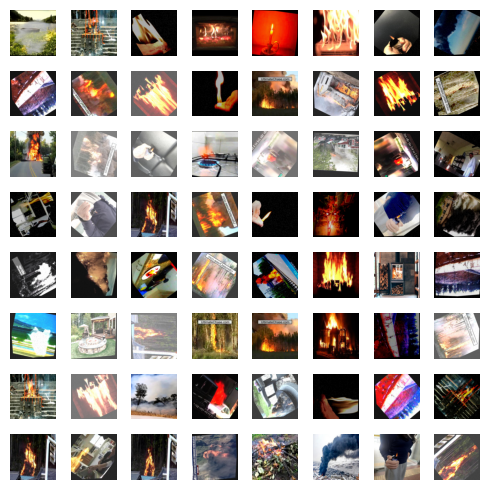

(640, 640, 3)


In [6]:
# Define dataset image path
image_folder = f"{dataset.location}/train/images"

# Get the first few image filenames 8*8=64 in our case here
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))][:64]

# Set up plot grid (8*8)
fig, axes = plt.subplots(8, 8, figsize=(5, 5))

# Loop through and plot images
for i, ax in enumerate(axes.flat):
    if i < len(image_files):
        img_path = os.path.join(image_folder, image_files[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis("off")

plt.tight_layout()
plt.show()
print(img.shape)

# Class Distribution

In [7]:
# Written Using colab, modify path for your system
label_folder_train = r"/content/Fire-Smoke-Detection-Yolov11-2/train/labels"
label_folder_val = r"/content/Fire-Smoke-Detection-Yolov11-2/valid/labels"
label_folder_test = r"/content/Fire-Smoke-Detection-Yolov11-2/test/labels"


def get_class_distribution(label_folder):
    class_counts = Counter()  # Initialize inside function
    bounded_boxes = []

    annotation_files = glob.glob(os.path.join(label_folder, '*.txt'))

    for filename in annotation_files:
        with open(filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                segments = line.strip().split()
                if len(segments) == 5:
                    class_id = int(segments[0])
                    x_center, y_center, width, height = map(float, segments[1:])
                    class_counts[class_id] += 1
                    bounded_boxes.append([x_center, y_center, width, height])
                else:
                    print(len(segments), "Skipping line with unexpected format:", segments)

    return class_counts, bounded_boxes

class_counts, bounded_boxes = get_class_distribution(label_folder_train)

box_df = pd.DataFrame(bounded_boxes, columns=['x_center', 'y_center', 'width', 'height'])

11 Skipping line with unexpected format: ['1', '0.9953125', '0.2140625', '0.34375', '0.2140625', '0.34375', '0.8796875', '0.9953125', '0.8796875', '0.9953125', '0.2140625']
15 Skipping line with unexpected format: ['1', '0', '0.3776808828125', '0.16484930312499999', '0.9060224390625', '0.810852234375', '0.7416070875', '0.5923860796875', '0.0414236703125', '0.5853536109374999', '0.0409319125', '0', '0.189911296875', '0', '0.3776808828125']
13 Skipping line with unexpected format: ['1', '0.33905216562499996', '0', '0.05445058125', '0.38516669531250003', '0.5965650515625', '0.78687930625', '0.9991538734375001', '0.24203410781249998', '0.672526853125', '0', '0.33905216562499996', '0']
11 Skipping line with unexpected format: ['1', '0.740625', '0.3078125', '0.0984375', '0.3078125', '0.0984375', '0.95625', '0.740625', '0.95625', '0.740625', '0.3078125']
11 Skipping line with unexpected format: ['1', '0.5523526999999999', '0.926379571875', '0.8330343671874999', '0.45012618125000003', '0.37199

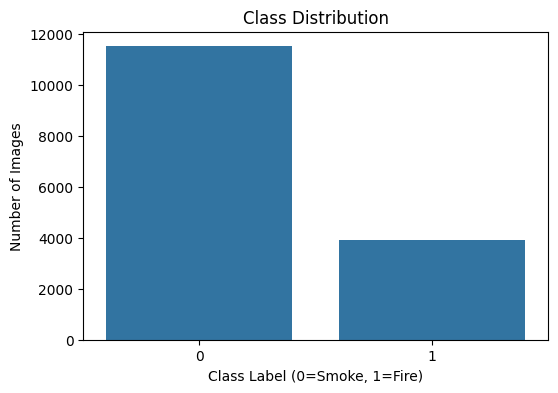

In [8]:
if class_counts:
    plt.figure(figsize=(6,4))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title('Class Distribution')
    plt.xlabel('Class Label (0=Smoke, 1=Fire)')
    plt.ylabel('Number of Images')
    plt.xticks([0, 1])
    plt.show()
else:
    print("No class distribution data available.") #Debug statment, No graph info means path above is wrong

Text(0, 0.5, 'Frequency')

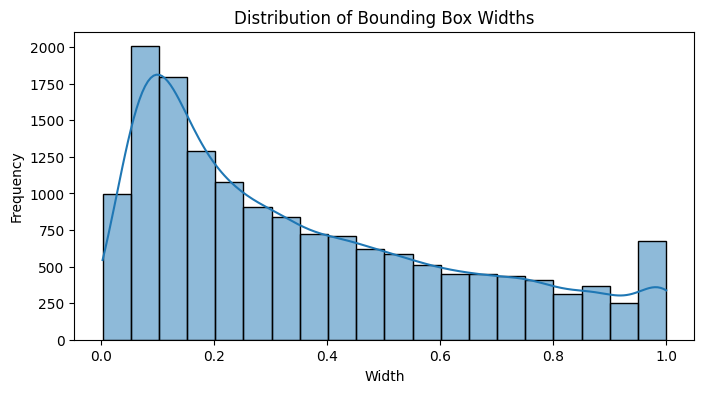

In [9]:
plt.figure(figsize=(8,4))
sns.histplot(box_df['width'], bins=20, kde=True)
plt.title('Distribution of Bounding Box Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

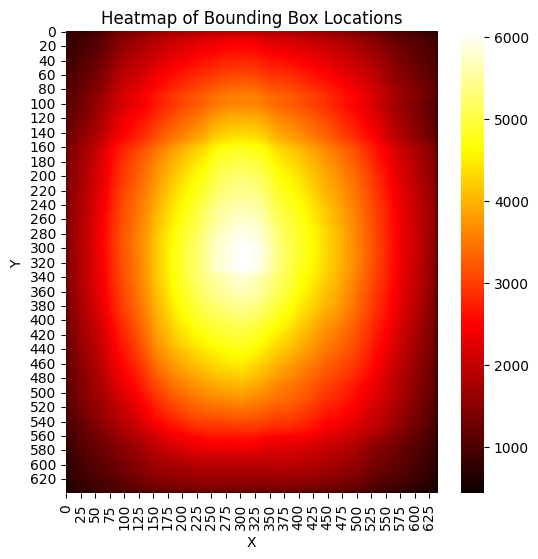

In [10]:
heatmap = np.zeros((640, 640))

for _, row in box_df.iterrows():
  x,y,w,h = row['x_center'], row['y_center'], row['width'], row['height']
  x1, y1 = int((x - w/2) * 640), int((y - h/2) * 640)
  x2, y2 = int((x + w/2) * 640), int((y + h/2) * 640)
  heatmap[y1:y2, x1:x2] += 1

plt.figure(figsize=(6,6))
sns.heatmap(heatmap, cmap='hot', cbar=True)
plt.title('Heatmap of Bounding Box Locations')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Model


Define Convolutional Block, This headder is used for both darknet and yolo

In [11]:
class ConvUnit(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvUnit, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leaky_relu(self.bn(self.conv(x)))


ResidualUnit is used a few times in darknet

In [12]:
class ResidualUnit(nn.Module):
    def __init__(self, in_channels):
        super(ResidualUnit, self).__init__()
        self.conv1 = ConvUnit(in_channels, in_channels//2, kernel_size=1, stride=1, padding=0)
        self.conv2 = ConvUnit(in_channels//2, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        return x + self.conv2(self.conv1(x))  # Skip connection


In [13]:
class Darknet53(nn.Module):
    def __init__(self):
        super(Darknet53, self).__init__()

        self.conv1 = ConvUnit(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = ConvUnit(32, 64, kernel_size=3, stride=2, padding=1)
        self.res1 = ResidualUnit(64)

        self.conv3 = ConvUnit(64, 128, kernel_size=3, stride=2, padding=1)
        self.res2 = nn.Sequential(ResidualUnit(128), ResidualUnit(128))

        self.conv4 = ConvUnit(128, 256, kernel_size=3, stride=2, padding=1)
        self.res3 = nn.Sequential(*[ResidualUnit(256) for _ in range(8)])

        self.conv5 = ConvUnit(256, 512, kernel_size=3, stride=2, padding=1)
        self.res4 = nn.Sequential(*[ResidualUnit(512) for _ in range(8)])

        self.conv6 = ConvUnit(512, 1024, kernel_size=3, stride=2, padding=1)
        self.res5 = nn.Sequential(*[ResidualUnit(1024) for _ in range(4)])

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x)
        x = self.conv3(x)
        x = self.res2(x)
        x = self.conv4(x)
        x = self.res3(x)
        x = self.conv5(x)
        x = self.res4(x)
        x = self.conv6(x)
        x = self.res5(x)
        return x


Yolo Head

In [14]:
class YOLOHead(nn.Module):
    def __init__(self, num_classes):
        super(YOLOHead, self).__init__()
        self.conv1 = ConvUnit(1024, 512, 1, 1, 0)
        self.conv2 = ConvUnit(512, 1024, 3, 1, 1)
        self.conv3 = nn.Conv2d(1024, (num_classes + 5) * 3, kernel_size=1)  # 3 anchors per grid cell

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x).reshape(x.shape[0], 3, -1, x.shape[2], x.shape[3])  # Reshape for YOLO anchors


Combine Yolo and Darknet Head

In [15]:
class YOLOv3(nn.Module):
    def __init__(self, num_classes=2):
        super(YOLOv3, self).__init__()
        self.backbone = Darknet53()
        self.yolo_head = YOLOHead(num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return self.yolo_head(x)


# Loss Function

In [16]:
class YOLOLoss(nn.Module):
    def __init__(self, num_classes, lambda_coord=5, lambda_noobj=0.5):
        super(YOLOLoss, self).__init__()
        self.num_classes = num_classes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.mse_loss = nn.MSELoss()  # For bounding box regression
        self.bce_loss = nn.BCEWithLogitsLoss()  # For objectness & class predictions

    def forward(self, predictions, targets):
        """
        Compute YOLO loss.

        Args:
        - predictions: Tensor of shape (batch_size, num_anchors, 7, grid_size, grid_size)
        - targets: Tensor of same shape as `predictions`

        Returns:
        - Total YOLO loss
        """
        # Reshape targets if necessary
        if targets.shape != predictions.shape:
            targets = targets.view_as(predictions)  # Match shape if needed

        # Extract components
        pred_boxes = predictions[:, :, :4]  # x, y, w, h
        pred_obj = predictions[:, :, 4]  # Object confidence score
        pred_class = predictions[:, :, 5:]  # Class probabilities

        target_boxes = targets[:, :, :4]  # Ground truth bbox
        target_obj = targets[:, :, 4]  # Ground truth objectness score
        target_class = targets[:, :, 5:]  # Ground truth class

        # Compute Bounding Box Loss (MSE)
        bbox_loss = self.mse_loss(pred_boxes, target_boxes)

        # Compute Objectness Loss (BCE)
        obj_loss = self.bce_loss(pred_obj, target_obj)

        # Compute Classification Loss (BCE)
        class_loss = self.bce_loss(pred_class, target_class)

        # Total Loss
        total_loss = (self.lambda_coord * bbox_loss) + obj_loss + (class_loss)

        return total_loss

In [17]:
# Initialize YOLO loss function
num_classes = 2
yolo_loss = YOLOLoss(num_classes)

# Generate random predictions & targets (simulating model output)
batch_size = 1
num_anchors = 3
grid_size = 13  # YOLOv3 uses 13x13, 26x26, and 52x52 grids

# Fake predictions: [batch, anchors, 7 (x, y, w, h, obj, class1, class2), grid, grid]
preds = torch.rand((batch_size, num_anchors, 7, grid_size, grid_size))

# Fake targets (ground truth labels in the same format)
targets = torch.rand((batch_size, num_anchors, 7, grid_size, grid_size))

# Compute loss
loss = yolo_loss(preds, targets)

print("Loss function test successful! Sample loss:", loss.item())
print("Output should be possitive and small")



Loss function test successful! Sample loss: 2.335050344467163
Out put should be possitive and small


In [18]:
class FireDataset(Dataset):
    def __init__(self, image_folder, label_folder, img_size=416, grid_size=13, num_anchors=3, num_classes=2):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.img_size = img_size
        self.grid_size = grid_size
        self.num_anchors = num_anchors
        self.num_classes = num_classes
        self.image_files = sorted(os.listdir(image_folder))
        self.label_files = sorted(os.listdir(label_folder))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        image = cv2.imread(img_path)
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image / 255.0  # Normalize to [0,1]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)

        # Load label
        label_path = os.path.join(self.label_folder, self.label_files[idx])
        labels = torch.zeros((self.num_anchors, 7, self.grid_size, self.grid_size))  # Empty grid

        with open(label_path, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, x, y, w, h = map(float, parts)

                    # Fix: Ensure grid coordinates stay within bounds
                    x_cell = min(int(x * self.grid_size), self.grid_size - 1)
                    y_cell = min(int(y * self.grid_size), self.grid_size - 1)

                    labels[:, :4, y_cell, x_cell] = torch.tensor([x, y, w, h])
                    labels[:, 4, y_cell, x_cell] = 1.0  # Object confidence
                    labels[:, 5 + int(class_id), y_cell, x_cell] = 1.0  # Class

        return image, labels  # Now labels match YOLO format



In [19]:
image_folder = "/content/Fire-Smoke-Detection-Yolov11-2/train/images"
label_folder = "/content/Fire-Smoke-Detection-Yolov11-2/train/labels"
dataset = FireDataset(image_folder, label_folder)

def collate_fn(batch):
    images, labels = zip(*batch)  # Unpack batch (tuple of images, labels)

    # Stack images into a single tensor batch
    images = torch.stack(images)

    # Stack labels properly
    labels = torch.stack(labels)

    return images, labels  # Now both images and labels are tensors

#CHANGE BATCH SIZE HERE!!!!!!!!!   32 is on the limit at 14.1 out of 15 for free colab.
# 64 uses 31 GB VRAM
# Create DataLoader with fixed collate_fn   BATCH SIZE CHNAGE HERE
dataloader = DataLoader(dataset, batch_size=80, shuffle=True, collate_fn=collate_fn)

#
for img, label in dataloader:
    print(" Dataset loaded successfully!")
    print(" Image Batch Shape:", img.shape)  # Expected: (batch_size, 3, 416, 416)
    print(" Label Batch Shape:", label.shape)  # Expected: (batch_size, max_objs, 5)
    break  # Stop after first batch


 Dataset loaded successfully!
 Image Batch Shape: torch.Size([80, 3, 416, 416])
 Label Batch Shape: torch.Size([80, 3, 7, 13, 13])


# Train

In [ ]:
#Checking device its running on
print("Device in Use:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


Device in Use: NVIDIA A100-SXM4-40GB


In [ ]:
#Checking batch size
for images, labels in dataloader:
    print(f"Batch Size: {images.shape[0]}")
    break  # Stop after first batch


Batch Size: 80


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = YOLOv3(num_classes=2).to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = YOLOLoss(num_classes=2)


In [ ]:
def train(model, dataloader, optimizer, loss_function, epochs, save_path="yolov3_fire_final.pth"):
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        total_loss = 0
        batch_losses = []  # Store batch losses for reporting
        all_preds = []  # Store all predictions
        all_targets = []  # Store all ground truth labels

        print(f"\n Epoch {epoch+1}/{epochs} - Training Started...")

        for batch_idx, (images, targets) in enumerate(dataloader):
            images = images.to(device)

            # Ensure targets are tensors & move to device
            if isinstance(targets, list):
                targets = torch.stack(targets).to(device)
            else:
                targets = targets.to(device)

            preds = model(images)  # Forward pass

            # Ensure target shape matches prediction shape
            if targets.shape != preds.shape:
                print(f"Skipping Batch {batch_idx+1} - Shape Mismatch: Targets {targets.shape}, Preds {preds.shape}")
                continue  # Skip this batch

            loss = loss_function(preds, targets)  # Compute YOLO loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batch_losses.append(loss.item())

            # Convert predictions to binary (1 = fire detected, 0 = no fire)
            pred_labels = (preds[:, :, 4] > 0.5).float().cpu().numpy()  # Objectness score thresholded
            true_labels = (targets[:, :, 4] > 0.5).float().cpu().numpy()  # Ground truth

            all_preds.extend(pred_labels.flatten())  # Store predictions
            all_targets.extend(true_labels.flatten())  # Store true labels

            # Print only every 20 batches
            if batch_idx % 20 == 0:
                avg_loss = sum(batch_losses) / len(batch_losses)
                print(f" Batch {batch_idx+1}/{len(dataloader)} - Avg Loss: {avg_loss:.4f}")

        # Compute Precision, Recall, and F1 Score
        precision = precision_score(all_targets, all_preds, zero_division=1)
        recall = recall_score(all_targets, all_preds, zero_division=1)
        f1 = f1_score(all_targets, all_preds, zero_division=1)

        print(f" Epoch {epoch+1}/{epochs} - Total Loss: {total_loss:.4f}")
        print(f" Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Save model **ONLY after training is complete**
    torch.save(model.state_dict(), save_path)
    print(f" Model saved at {save_path}")




In [ ]:
num_epochs = 50  # Adjust this number as needed
train(model, dataloader, optimizer, yolo_loss, epochs=num_epochs)


 Epoch 1/50 - Training Started...
 Batch 1/115 - Avg Loss: 2.2731
 Batch 21/115 - Avg Loss: 2.4627
 Batch 41/115 - Avg Loss: 1.3340
 Batch 61/115 - Avg Loss: 0.9334
 Batch 81/115 - Avg Loss: 0.7277
 Batch 101/115 - Avg Loss: 0.6019
 Epoch 1/50 - Total Loss: 62.1591
 Precision: 0.0093, Recall: 0.0004, F1 Score: 0.0008

 Epoch 2/50 - Training Started...
 Batch 1/115 - Avg Loss: 0.0926
 Batch 21/115 - Avg Loss: 0.0919
 Batch 41/115 - Avg Loss: 0.0915
 Batch 61/115 - Avg Loss: 0.0903
 Batch 81/115 - Avg Loss: 0.0897
 Batch 101/115 - Avg Loss: 0.0889
 Epoch 2/50 - Total Loss: 10.1578
 Precision: 1.0000, Recall: 0.0000, F1 Score: 0.0000

 Epoch 3/50 - Training Started...
 Batch 1/115 - Avg Loss: 0.1139
 Batch 21/115 - Avg Loss: 0.0886
 Batch 41/115 - Avg Loss: 0.0877
 Batch 61/115 - Avg Loss: 0.0855
 Batch 81/115 - Avg Loss: 0.0848
 Batch 101/115 - Avg Loss: 0.0842
 Epoch 3/50 - Total Loss: 9.6447
 Precision: 1.0000, Recall: 0.0000, F1 Score: 0.0000

 Epoch 4/50 - Training Started...
 Batch

# TEST

In [ ]:
model = YOLOv3(num_classes=2)  # Initialize the model architecture
model.load_state_dict(torch.load("yolov3_fire_final.pth"))  # Load trained weights
model.to(device)  # Move to GPU/CPU
model.eval()  # Set model to evaluation mode


YOLOv3(
  (backbone): Darknet53(
    (conv1): ConvUnit(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.1)
    )
    (conv2): ConvUnit(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.1)
    )
    (res1): ResidualUnit(
      (conv1): ConvUnit(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (leaky_relu): LeakyReLU(negative_slope=0.1)
      )
      (conv2): ConvUnit(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05,

# Testing unknown image on model

In [30]:
# Only run this block if importing model if traning ignore
# Run model above before this
#  Initialize YOLOv3 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLOv3(num_classes=2).to(device)

#  Load trained weights
model.load_state_dict(torch.load("/content/yolov3_fire_final.pth", map_location=device))

#  Set model to evaluation mode
model.eval()

print("YOLOv3 Model Loaded Successfully!")


YOLOv3 Model Loaded Successfully!


In [27]:
print(" Model Device:", next(model.parameters()).device)
print(" Model Parameters Loaded:", any(p.requires_grad for p in model.parameters()))
def non_max_suppression(predictions, conf_threshold=0.5, iou_threshold=0.5):
    """
    Apply Non-Maximum Suppression (NMS) to remove overlapping bounding boxes.
    """
    outputs = []
    for pred in predictions:
        if pred is None or len(pred) == 0:
            continue

        # Convert tensor to correct shape
        pred = pred.view(-1, 7)
        pred = pred[pred[:, 4] > conf_threshold]  # Filter by confidence

        if pred.shape[0] == 0:
            continue

        # Extract bounding boxes and scores
        boxes = pred[:, :4]
        scores = pred[:, 4]

        # Convert YOLO boxes to (xmin, ymin, xmax, ymax) format
        boxes = box_convert(boxes, in_fmt="cxcywh", out_fmt="xyxy")

        # Apply NMS
        keep_indices = nms(boxes, scores, iou_threshold)
        keep_boxes = pred[keep_indices]

        outputs.append(keep_boxes if len(keep_boxes) > 0 else None)

    return outputs

 Model Device: cuda:0
 Model Parameters Loaded: True


In [28]:
def detect_fire(model, image_path, conf_threshold=0.51, iou_threshold=0.6):
    """
    Detects fire in an image using a trained YOLO model.

    Args:
    - model: Trained YOLO model
    - image_path: Path to the image to detect fire
    - conf_threshold: Confidence threshold for detections
    - iou_threshold: IoU threshold for non-max suppression

    Returns:
    - Detections with bounding boxes, confidence scores, and class probabilities
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image '{image_path}'")
        return None

    image = cv2.resize(image, (416, 416))
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        preds = model(image)

    # Apply sigmoid activation to confidence and class scores
    preds[..., 4] = torch.sigmoid(preds[..., 4])  # Object confidence
    preds[..., 5:] = torch.sigmoid(preds[..., 5:])  # Class scores

    # Apply Non-Maximum Suppression (NMS)
    preds = non_max_suppression(preds, conf_threshold, iou_threshold)

    if not preds or len(preds) == 0:
        print("No detections found after NMS.")

    return preds

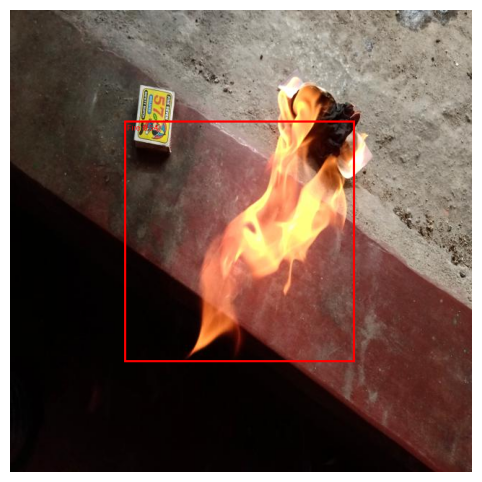

In [29]:

def visualize_detections(image_path, detections):
    """
    Displays YOLO detections using `draw_bounding_boxes` from torchvision.

    Args:
    - image_path: Path to the image
    - detections: YOLO detections (list of tensors)
    """
    image = Image.open(image_path).convert("RGB")
    orig_w, orig_h = image.size
    image = F.to_tensor(image)
    image = image[:3, ...]

    pred_labels = []
    pred_boxes = []

    for box in detections:
        box = box.cpu().numpy()
        if len(box) < 6:
            print(f"Skipping invalid detection: {box}")
            continue

        # Extract YOLO format: (center_x, center_y, width, height)
        center_x, center_y, width, height, conf = box[:5]
        class_probs = box[5:]
        class_id = int(class_probs.argmax())

        # Convert YOLO format to pixel coordinates
        x1, y1, x2, y2 = pbx.convert_bbox(
            (center_x, center_y, width, height), from_type="yolo", to_type="voc", image_size=(orig_w, orig_h)
        )

        # Ensure bounding boxes are within valid bounds
        x1, y1 = max(0, int(x1)), max(0, int(y1))
        x2, y2 = min(orig_w - 1, int(x2)), min(orig_h - 1, int(y2))

        if x1 >= x2 or y1 >= y2:
            print(f"Skipping invalid bounding box: [{x1}, {y1}, {x2}, {y2}]")
            continue

        # Class labels
        class_names = ["Fire", "Smoke"]
        label = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
        pred_labels.append(f"{label}: {conf:.2f}")
        pred_boxes.append([x1, y1, x2, y2])

    if pred_boxes:
        pred_boxes = torch.tensor(pred_boxes, dtype=torch.int64)
        output_image = draw_bounding_boxes(image, pred_boxes, labels=pred_labels, colors="red", width=3)
    else:
        output_image = image

    plt.figure(figsize=(10, 6))
    plt.imshow(to_pil_image(output_image))
    plt.axis("off")
    plt.show()

# Run Detection & Visualization
detections = detect_fire(model, "/content/fire_image2.jpg")
if detections and len(detections) > 0:
    visualize_detections("/content/fire_image2.jpg", detections[0])


# Visuals

In [ ]:
print(model)


YOLOv3(
  (backbone): Darknet53(
    (conv1): ConvUnit(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.1)
    )
    (conv2): ConvUnit(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.1)
    )
    (res1): ResidualUnit(
      (conv1): ConvUnit(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (leaky_relu): LeakyReLU(negative_slope=0.1)
      )
      (conv2): ConvUnit(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05,

In [ ]:
from torchsummary import summary

# Ensure model is on the correct device (GPU/CPU)
model.to(device)

# Print model summary for input size (3, 416, 416)
summary(model, (3, 416, 416))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 416, 416]             864
       BatchNorm2d-2         [-1, 32, 416, 416]              64
         LeakyReLU-3         [-1, 32, 416, 416]               0
          ConvUnit-4         [-1, 32, 416, 416]               0
            Conv2d-5         [-1, 64, 208, 208]          18,432
       BatchNorm2d-6         [-1, 64, 208, 208]             128
         LeakyReLU-7         [-1, 64, 208, 208]               0
          ConvUnit-8         [-1, 64, 208, 208]               0
            Conv2d-9         [-1, 32, 208, 208]           2,048
      BatchNorm2d-10         [-1, 32, 208, 208]              64
        LeakyReLU-11         [-1, 32, 208, 208]               0
         ConvUnit-12         [-1, 32, 208, 208]               0
           Conv2d-13         [-1, 64, 208, 208]          18,432
      BatchNorm2d-14         [-1, 64, 2

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params}")


Total Parameters: 45852405


In [ ]:
num_layers = len(list(model.modules()))
num_conv_layers = sum(1 for layer in model.modules() if isinstance(layer, torch.nn.Conv2d))
num_linear_layers = sum(1 for layer in model.modules() if isinstance(layer, torch.nn.Linear))

print(f"Total Layers: {num_layers}")
print(f"Convolutional Layers: {num_conv_layers}")
print(f"Fully Connected (Linear) Layers: {num_linear_layers}")


Total Layers: 247
Convolutional Layers: 55
Fully Connected (Linear) Layers: 0


In [ ]:
import torchviz
from torchviz import make_dot

# Generate a dummy input to visualize the computation graph
dummy_input = torch.randn(1, 3, 416, 416).to(device)
output = model(dummy_input)

# Create the visualization
make_dot(output, params=dict(model.named_parameters())).render("yolo_graph", format="png")

print("Model graph saved as 'yolo_graph.png'")


Model graph saved as 'yolo_graph.png'
